# Homework 1

## Preparations

### Data Loading

In [1]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
torch.manual_seed(2022)

batchsize = 128  # training batch size
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(
    root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batchsize, shuffle=True, num_workers=1)

testset = datasets.MNIST(
    root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=False, num_workers=1)

/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Some introductions of the MNIST dataset
1. Some quantitative descriptions of the whole dataset \
There are 60000 images in the training set and 10000 images in the test set, the size of single image is (28, 28).

In [2]:
print(trainset.data.shape, trainset.targets.shape)
print(testset.data.shape, testset.targets.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


2. Some quantitative descriptions of a single image \
The raw data is taken value in \[0, 255\] using integer format. \
For example, you can print the first data in trainset to verify. \
We can also access the data by **dataloader**, and usually take this way. \
However, the data obtained in this way are transformed by specified transformations, and the range of value will also change. \
In this homework, how these transformations works is not important.

In [3]:
img1 = trainset.data[0]  # one image from trainset
print(img1.shape)
print(img1)

imgs, labels = next(iter(trainloader))  # get a batch of data from trainloader randomly
img2 = imgs[0]
print(imgs.shape, img2.shape)
# print(img2)

torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,  

3. Some intuitive illustrations of the dataset \
Here we illustrate the first five images in the trainset.

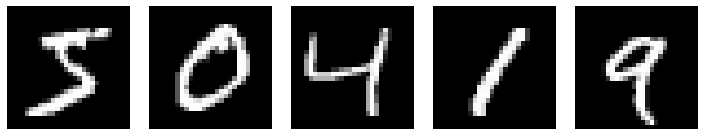

In [4]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(2*n, 2))
for i in range(n):
    img = trainset.data[i]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_axis_off()
plt.tight_layout()

### Import

In [5]:
import torch
import math
import time

### Define Layers

In [6]:
class Layer(object):
    def __init__(self):
        self._saved_tensor = None

    def forward(self, input):
        pass

    def backward(self, grad_output):
        pass

    def _saved_for_backward(self, tensor):
        '''The intermediate results computed during forward stage
        can be saved and reused for backward, for saving computation'''

        self._saved_tensor = tensor

    def parameters(self):
        return []


class ReLU(Layer):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, input):
        # TODO: implement this function, return the output
        self._saved_for_backward(input)
        return torch.clamp(input, min=0)
        pass

    def backward(self, grad_output):
        # TODO: implement this function, return the gradient w.r.t. input
        relu_mask = (self._saved_tensor >= 0)
        grad_input = grad_output * relu_mask
        return grad_input
        pass


class Sigmoid(Layer):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, input):
        # TODO, implement this function, return the output
        output = 1 / (1+torch.exp(-input))
        self._saved_for_backward(output)
        return output
        pass

    def backward(self, grad_output):
        # TODO, implement this function, return the gradient w.r.t. input
        output = self._saved_tensor
        return grad_output * output * (1-output)
        pass


class Linear(Layer):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # initialization
        bound = 1 / math.sqrt(in_features)
        self.weight = torch.empty(out_features, in_features)
        self.weight.uniform_(-bound, bound)
        self.bias = torch.empty(out_features)
        self.bias.uniform_(-bound, bound)

    def forward(self, input):
        # TODO: implement this function, return the output
        self._saved_for_backward(input)
        return input @ self.weight.t() + self.bias
        pass

    def backward(self, grad_output):
        # 1. return the gradient w.r.t. input
        grad_input = grad_output.matmul(self.weight)
        # 2. store the gradient w.r.t. parameters in `weight.grad` and `bias.grad`
        # batch_size = grad_output.shape[0]
        self.weight.grad = grad_output.t() @ self._saved_tensor
        self.bias.grad = torch.einsum('i...->...', grad_output)
        # TODO: complete this function
        return grad_input

    def parameters(self):
        return [self.weight, self.bias]


### Define Loss Function

In [7]:
class MSELoss(object):
    def forward(self, input, target):
        # TODO: implement this function, return the scalar output
        return torch.mean((input-target)**2)
        pass

    def backward(self, input, target):
        # TODO: implement this function, return the gradient w.r.t. input
        dx = 2 * (input-target) / torch.numel(input)
        return dx
        pass


class BCELoss(object):
    def forward(self, input, target):
        # TODO: implement this function, return the scalar output
        return torch.mean(-(torch.log(input) * target + torch.log(1-input) * (1-target)))
        pass

    def backward(self, input, target):
        # TODO: implement this function, return the gradient w.r.t. input
        return (input-target) / target.size(dim=0)
        pass


class CrossEntropyLoss(object):
    def forward(self, input, target):
        # TODO: implement this function, return the scalar output
        yhat = input.exp() / input.exp().sum(dim=1, keepdim=True)
        return - torch.log(yhat.gather(1, target.view(-1, 1))).mean()
        pass

    def backward(self, input, target):
        # TODO: implement this function, return the gradient w.r.t. input
        dim_target = target.size(dim=0)
        gt = torch.zeros(dim_target, input.size(dim=1)).scatter(1, target.view(dim_target,1),1)
        yhat = input.exp() / input.exp().sum(dim=1, keepdim=True)
        return (yhat-gt) / dim_target
        pass


### Define Model

In [8]:
class Sequential(object):
    def __init__(self):
        self.layers = []
        self.num_layers = 0

    def append(self, layer):
        self.layers.append(layer)
        self.num_layers += 1

    def forward(self, x):
        out = x
        for i in range(self.num_layers):
            out = self.layers[i].forward(out)
        return out

    def backward(self, grad_output):
        grad_input = grad_output
        for i in range(self.num_layers - 1, -1, -1):
            grad_input = self.layers[i].backward(grad_input)

    def parameters(self):
        parameters = []
        for i in range(self.num_layers):
            parameters += self.layers[i].parameters()
        return parameters


class LogisticRegression(Sequential):
    def __init__(self, in_features):
        super(LogisticRegression, self).__init__()
        # TODO: construct the logistic regression function
        lr = Linear(in_features, 1)
        s= Sigmoid()
        self.append(lr)
        self.append(s)
        pass


class TwoLayerNet(Sequential):
    def __init__(self, input_dim, num_classes, hidden_dims) -> None:
        super(TwoLayerNet, self).__init__()
        
        # TODO: construct a neural network with one hidden layer, using ReLU activation
        lr1 = Linear(input_dim, hidden_dims)
        s1 = ReLU()
        lr2 = Linear(hidden_dims, num_classes)
        s2 = ReLU()
        
        self.append(lr1)
        self.append(s1)
        self.append(lr2)
        self.append(s2)
        pass


### Verification
We use the tools in **autograd** and **torch.nn** to give a correctness check for the manual implementation. \
Afterwards, we will use these 'tools' in network training directly. \
Here we give a example for CrossEntropyLoss, and you can modify the **input and target** to check other loss functions. \
Next, with the help of loss function, you can check the correctess of layers(Linear, ReLU, Sigmoid).

In [9]:
import torch.nn as nn


def equal(tensor1, tensor2):
    diff = (tensor1 - tensor2).abs().max()
    return diff < 1e-5


def correctness_test_for_cross_entropy_loss():
    loss_standard = nn.CrossEntropyLoss()
    loss_ours = CrossEntropyLoss()

    # input and target
    input = torch.randn(3, 5, requires_grad=True)
    target = torch.empty(3, dtype=torch.long).random_(5)

    # autograd computation
    output_standard = loss_standard(input, target)
    output_standard.backward()
    grad_standard = input.grad.clone()

    # our manual computation
    with torch.no_grad():
        output_ours = loss_ours.forward(input, target)
        grad_ours = loss_ours.backward(input, target)

    print("CrossEntropyLoss:")
    print("Forward Correct") if equal(output_ours, output_standard) else print("Forward Wrong")
    print("Backward Correct") if equal(grad_ours, grad_standard) else print("Backward Wrong")


correctness_test_for_cross_entropy_loss()


# You can use nn.MSELoss, nn.BCELoss, nn.Linear, nn.Sigmoid, nn.ReLU to do left correctness check
def correctness_test_for_mse_loss():
    loss_standard = nn.MSELoss()
    loss_ours = MSELoss()

    # input and target
    input = torch.randn(3, 5, requires_grad=True)
    target = torch.randn(3, 5)

    # autograd computation
    output_standard = loss_standard(input, target)
    output_standard.backward()
    grad_standard = input.grad.clone()

    # our manual computation
    with torch.no_grad():
        output_ours = loss_ours.forward(input, target)
        grad_ours = loss_ours.backward(input, target)

    print("MSELoss:")
    print("Forward Correct") if equal(output_ours, output_standard) else print("Forward Wrong")
    print("Backward Correct") if equal(grad_ours, grad_standard) else print("Backward Wrong") 


correctness_test_for_mse_loss()


def correctness_test_for_bce_loss():
    loss_standard = nn.BCELoss()
    loss_ours = BCELoss()

    # input and target
    s = nn.Sigmoid()
    input = torch.randn(3, requires_grad=True)
    target = torch.empty(3).random_(2)

    # autograd computation
    output_standard = loss_standard(s(input), target)
    output_standard.backward()
    grad_standard = input.grad.clone()

    # our manual computation
    with torch.no_grad():
        output_ours = loss_ours.forward(s(input), target)
        grad_ours = loss_ours.backward(s(input), target)

    print("BCELoss:")
    print("Forward Correct") if equal(output_ours, output_standard) else print("Forward Wrong")
    print("Backward Correct") if equal(grad_ours, grad_standard) else print("Backward Wrong")


correctness_test_for_bce_loss()


def correctness_test_for_sigmoid():
    sigmoid_standard = nn.Sigmoid()
    sigmoid_ours = Sigmoid()

    input = torch.randn(5, requires_grad=True)

    # autograd computation
    output_standard = sigmoid_standard(input)
    output_standard.backward(torch.ones_like(input), retain_graph=True)
    grad_standard = input.grad.clone()

    # our manual computation
    with torch.no_grad():
        output_ours = sigmoid_ours.forward(input)
        grad_ours = sigmoid_ours.backward(torch.ones_like(input))

    print("Sigmoid:")
    print("Forward Correct") if equal(output_ours, output_standard) else print("Forward Wrong")
    print("Backward Correct") if equal(grad_ours, grad_standard) else print("Backward Wrong")


correctness_test_for_sigmoid()


def correctness_test_for_relu():
    relu_standard = nn.ReLU()
    relu_ours = ReLU()

    input = torch.randn(5, 2, requires_grad=True)

    # autograd computation
    output_standard = relu_standard(input)
    output_standard.backward(torch.ones_like(input), retain_graph=True)
    grad_standard = input.grad.clone()

    # our manual computation
    with torch.no_grad():
        output_ours = relu_ours.forward(input)
        grad_ours = relu_ours.backward(torch.ones_like(input))

    print("ReLU:")
    print("Forward Correct") if equal(output_ours, output_standard) else print("Forward Wrong")
    print("Backward Correct") if equal(grad_ours, grad_standard) else print("Backward Wrong")


correctness_test_for_relu()


CrossEntropyLoss:
Forward Correct
Backward Correct
MSELoss:
Forward Correct
Backward Correct
BCELoss:
Forward Correct
Backward Correct
Sigmoid:
Forward Correct
Backward Correct
ReLU:
Forward Correct
Backward Correct


### Define Optimizer

In [10]:
class SGD(object):
    def __init__(self, parameters, lr):
        assert type(parameters) is list
        # Note: In the built-in optimizers like torch.optim.SGD in pytorch, the type of the fisrt parameter 'parameters' is 'generator' rather than 'list'.
        # For simplification, we use the 'list' type for 'parameters' here and you can just care about how the optimizer works.
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self):
        for p in self.parameters:
            p.grad = torch.zeros_like(p)

    @torch.no_grad()
    def step(self):
        for p in self.parameters:
            # TODO, compute the update vector in gradient descent
            upd = lr * p.grad
            p.data -= upd


## Step 1: Logistic Regression

### Trainer

In [11]:
# utils
def binarize_label(labels, interested):
    return (labels == interested).float()


# Training for Logstic Regression
def train(model, criterion, train_loader, optimizer, epoch, logging_steps):

    loss_list = []
    acc_list = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # 0. data preprocessing
        inputs = torch.flatten(inputs, start_dim=1)
        targets = binarize_label(targets, interested=interested_label)
        targets.unsqueeze_(dim=1)

        # 1. reset gradient to zero
        optimizer.zero_grad()

        # 2. forward computation
        outputs = model.forward(inputs)
        loss = criterion.forward(outputs, targets)

        # 3. backward computation
        # compute gradient w.r.t. output
        grad_output = criterion.backward(outputs, targets)
        # compute gradient w.r.t. parameters
        model.backward(grad_output)

        # 4. update parameters
        optimizer.step()

        # log
        predicted = (outputs >= 0.5).float()
        total = targets.size(0)
        correct = predicted.eq(targets).sum().item()
        acc = correct / total
        loss_list.append(loss.item())
        acc_list.append(acc)

        if batch_idx % logging_steps == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.3f}\tAcc: {:.3f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                loss_list[-1], acc_list[-1]))

    return loss_list, acc_list


# Validation for Logstic Regression
def test(model, criterion, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    num_batches = 0
    for inputs, targets in test_loader:
        inputs = torch.flatten(inputs, start_dim=1)
        targets = binarize_label(targets, interested=interested_label)
        targets.unsqueeze_(dim=1)

        outputs = model.forward(inputs)
        loss = criterion.forward(outputs, targets)

        # log
        test_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        num_batches += 1

    test_loss /= num_batches
    test_acc = correct / total
    return test_loss, test_acc


### Set Hyperparameters

In [12]:
num_epochs = 15  # training epochs
lr = 0.01  # learning rate
logging_steps = 64  # logging batchsize
best_acc = 0.0  # best accuracy

interested_label = 3

### Model, Loss Function and Optimizer

In [13]:
model = LogisticRegression(in_features=784)
# criterion = BCELoss()
criterion = MSELoss()
optimizer = SGD(model.parameters(), lr=lr)

### Main Loop

In [14]:
print("Step 1: Logistic Regression")

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    tic = time.time()
    loss_list, acc_list = train(model, criterion, trainloader, optimizer, epoch, logging_steps)
    test_loss, test_acc = test(model, criterion, testloader)
    t = time.time() - tic

    train_loss_list.append(torch.mean(torch.as_tensor(loss_list)))
    train_acc_list.append(torch.mean(torch.as_tensor(acc_list)))
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
    print(f"Epoch {epoch} | Total Time: {t:.0f}s, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")
print(f"Best Accuracy: {best_acc:.3f}")


Step 1: Logistic Regression
Train Epoch: 0 [0/60000]	Loss: 0.223	Acc: 0.602
Train Epoch: 0 [8192/60000]	Loss: 0.043	Acc: 0.953
Train Epoch: 0 [16384/60000]	Loss: 0.074	Acc: 0.906
Train Epoch: 0 [24576/60000]	Loss: 0.045	Acc: 0.945
Train Epoch: 0 [32768/60000]	Loss: 0.043	Acc: 0.953
Train Epoch: 0 [40960/60000]	Loss: 0.036	Acc: 0.977
Train Epoch: 0 [49152/60000]	Loss: 0.022	Acc: 0.984
Train Epoch: 0 [57344/60000]	Loss: 0.021	Acc: 0.984
Epoch 0 | Total Time: 24s, Test Loss: 0.031, Test Acc: 0.966
Train Epoch: 1 [0/60000]	Loss: 0.029	Acc: 0.969
Train Epoch: 1 [8192/60000]	Loss: 0.020	Acc: 0.984
Train Epoch: 1 [16384/60000]	Loss: 0.042	Acc: 0.945
Train Epoch: 1 [24576/60000]	Loss: 0.022	Acc: 0.977
Train Epoch: 1 [32768/60000]	Loss: 0.012	Acc: 0.984
Train Epoch: 1 [40960/60000]	Loss: 0.024	Acc: 0.969
Train Epoch: 1 [49152/60000]	Loss: 0.035	Acc: 0.961
Train Epoch: 1 [57344/60000]	Loss: 0.029	Acc: 0.977
Epoch 1 | Total Time: 23s, Test Loss: 0.026, Test Acc: 0.972
Train Epoch: 2 [0/60000]	Los

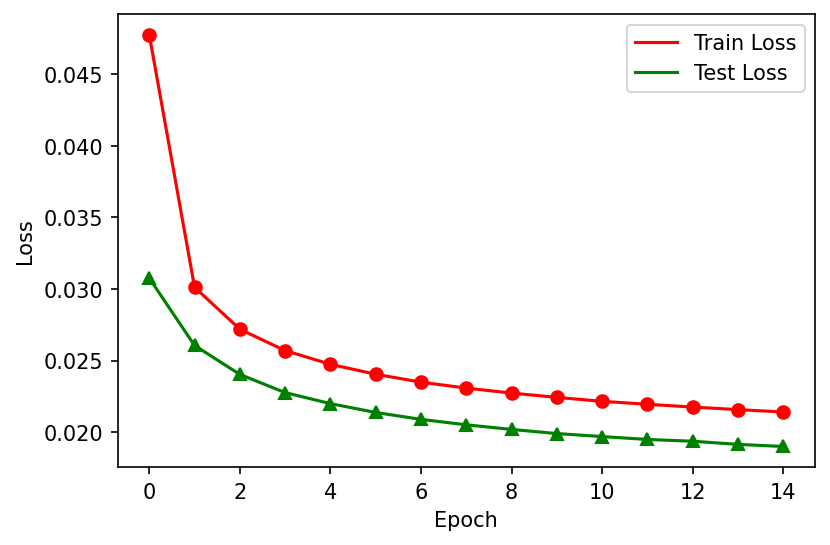

In [15]:
# plot loss and accuracy
epoch_list = range(num_epochs)
plt.figure(dpi=150)
l1 = plt.plot(epoch_list, train_loss_list, 'r-', label='Train Loss')
l2 = plt.plot(epoch_list, test_loss_list, 'g-', label='Test Loss')
plt.plot(epoch_list, train_loss_list, 'ro', epoch_list, test_loss_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

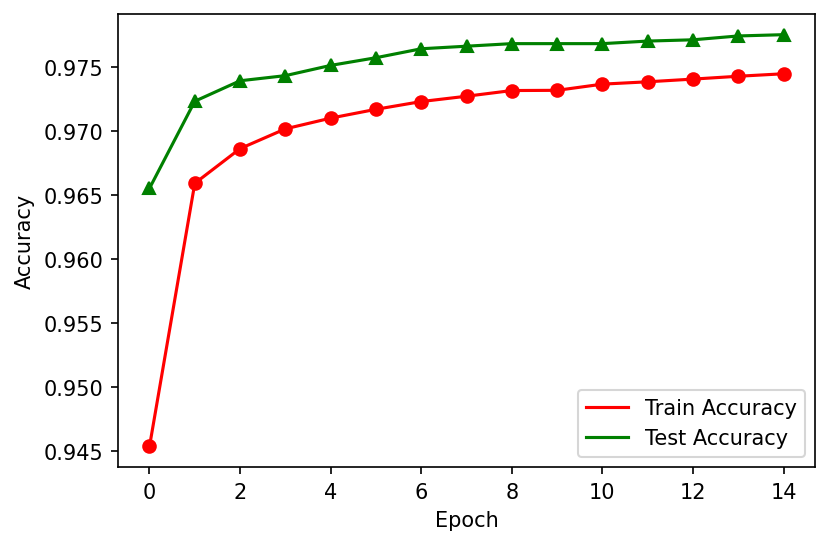

In [16]:
plt.figure(dpi=150)
l3 = plt.plot(epoch_list, train_acc_list, 'r-', label='Train Accuracy')
l4 = plt.plot(epoch_list, test_acc_list, 'g-', label='Test Accuracy')
plt.plot(epoch_list, train_acc_list, 'ro', epoch_list, test_acc_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Step 2: MLP Classification

### Trainer

In [35]:
# utils
def onehot_encoding(targets, num_classes):
    eye = torch.eye(num_classes)
    onehot_targets = eye[targets]
    return onehot_targets


# Training for MLP Classification
def train(model, criterion, train_loader, optimizer, epoch, logging_steps):

    loss_list = []
    acc_list = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # 0. data preprocessing
        inputs = torch.flatten(inputs, start_dim=1)

        # 1. reset gradient to zero
        optimizer.zero_grad()

        # 2. forward computation
        outputs = model.forward(inputs)

        loss = criterion.forward(outputs, targets)
#         loss = criterion.forward(outputs, onehot_encoding(targets, 10))  # for MSELoss
        
        # 3. backward computation
        # compute gradient w.r.t. output
        grad_output = criterion.backward(outputs, targets)
#         grad_output = criterion.backward(outputs, onehot_encoding(targets, 10))  # for MSELoss
        
        # compute gradient w.r.t. parameters
        model.backward(grad_output)

        # 4. update parameters
        optimizer.step()

        # log
        _, predicted = outputs.max(1)
        total = targets.size(0)
        correct = predicted.eq(targets).sum().item()
        acc = correct / total
        loss_list.append(loss.item())
        acc_list.append(acc)

        if batch_idx % logging_steps == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.3f}\tAcc: {:.3f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                loss_list[-1], acc_list[-1]))

    return loss_list, acc_list


# Validation for MLP Classification
def test(model, criterion, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    num_batches = 0
    for inputs, targets in test_loader:
        inputs = torch.flatten(inputs, start_dim=1)

        outputs = model.forward(inputs)
        loss = criterion.forward(outputs, targets)
#         loss = criterion.forward(outputs, onehot_encoding(targets, 10))  # for MSELoss

        # log
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        num_batches += 1

    test_loss /= num_batches
    test_acc = correct / total
    return test_loss, test_acc


### Set Hyperparameters

In [36]:
num_epochs = 15  # training epochs
lr = 0.01  # learning rate
logging_steps = 100  # logging batchsize
best_acc = 0.0  # best accuracy

### Model, Loss Function and Optimizer

In [37]:
model = TwoLayerNet(input_dim=784, num_classes=10, hidden_dims=300)
criterion = CrossEntropyLoss()
# criterion = MSELoss()
optimizer = SGD(model.parameters(), lr=lr)

### Main Loop

In [38]:
print("Step 2: MLP Classification")

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    tic = time.time()
    loss_list, acc_list = train(model, criterion, trainloader, optimizer, epoch, logging_steps)
    test_loss, test_acc = test(model, criterion, testloader)
    t = time.time() - tic
    
    train_loss_list.append(torch.mean(torch.as_tensor(loss_list)))
    train_acc_list.append(torch.mean(torch.as_tensor(acc_list)))
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
    print(f"Epoch {epoch} | Total Time: {t:.0f}s, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")
print(f"Best Accuracy: {best_acc:.3f}")


Step 2: MLP Classification
Train Epoch: 0 [0/60000]	Loss: 2.301	Acc: 0.125
Train Epoch: 0 [12800/60000]	Loss: 1.112	Acc: 0.789
Train Epoch: 0 [25600/60000]	Loss: 0.681	Acc: 0.820
Train Epoch: 0 [38400/60000]	Loss: 0.499	Acc: 0.867
Train Epoch: 0 [51200/60000]	Loss: 0.526	Acc: 0.844
Epoch 0 | Total Time: 13s, Test Loss: 0.396, Test Acc: 0.894
Train Epoch: 1 [0/60000]	Loss: 0.278	Acc: 0.930
Train Epoch: 1 [12800/60000]	Loss: 0.443	Acc: 0.914
Train Epoch: 1 [25600/60000]	Loss: 0.279	Acc: 0.930
Train Epoch: 1 [38400/60000]	Loss: 0.370	Acc: 0.867
Train Epoch: 1 [51200/60000]	Loss: 0.393	Acc: 0.859
Epoch 1 | Total Time: 13s, Test Loss: 0.311, Test Acc: 0.912
Train Epoch: 2 [0/60000]	Loss: 0.430	Acc: 0.859
Train Epoch: 2 [12800/60000]	Loss: 0.283	Acc: 0.914
Train Epoch: 2 [25600/60000]	Loss: 0.221	Acc: 0.938
Train Epoch: 2 [38400/60000]	Loss: 0.370	Acc: 0.883
Train Epoch: 2 [51200/60000]	Loss: 0.272	Acc: 0.914
Epoch 2 | Total Time: 14s, Test Loss: 0.276, Test Acc: 0.920
Train Epoch: 3 [0/6000

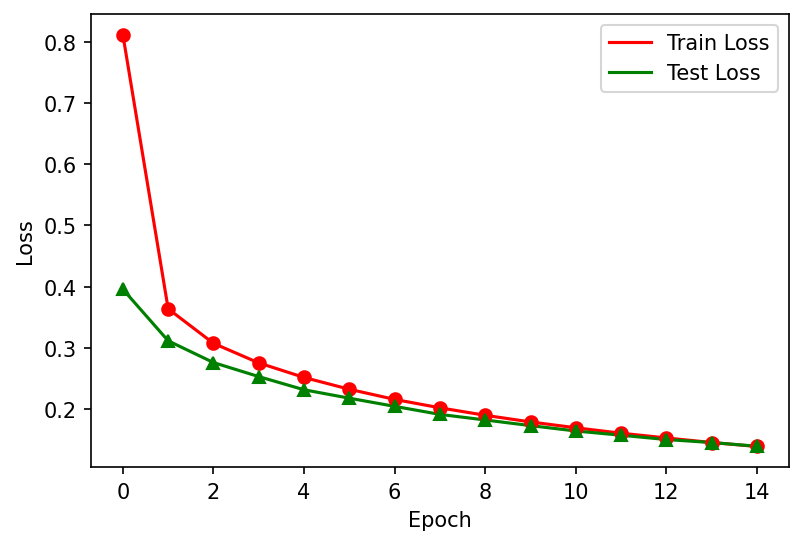

In [39]:
# plot loss and accuracy
epoch_list = range(num_epochs)
plt.figure(dpi=150)
l1 = plt.plot(epoch_list, train_loss_list, 'r-', label='Train Loss')
l2 = plt.plot(epoch_list, test_loss_list, 'g-', label='Test Loss')
plt.plot(epoch_list, train_loss_list, 'ro', epoch_list, test_loss_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

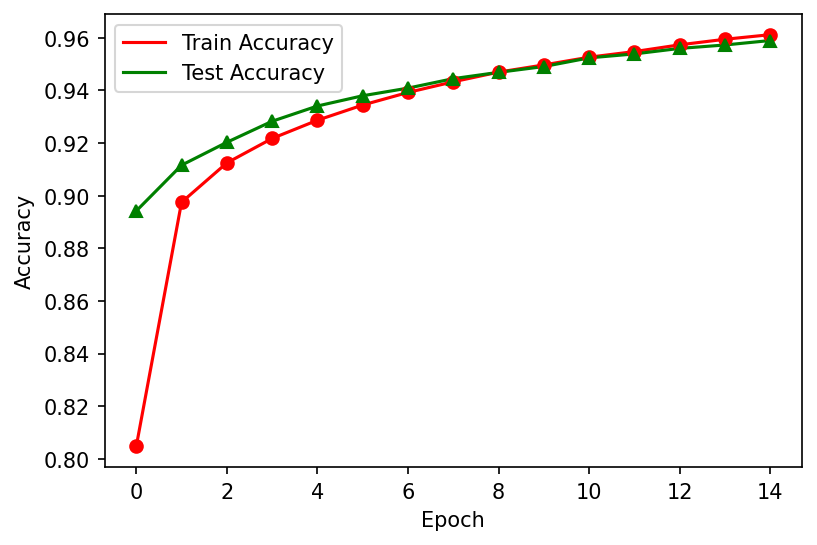

In [40]:
plt.figure(dpi=150)
l3 = plt.plot(epoch_list, train_acc_list, 'r-', label='Train Accuracy')
l4 = plt.plot(epoch_list, test_acc_list, 'g-', label='Test Accuracy')
plt.plot(epoch_list, train_acc_list, 'ro', epoch_list, test_acc_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Step 3: Training with Autograd

### Autograd Introduction
#### Example 1

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)
tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward>)


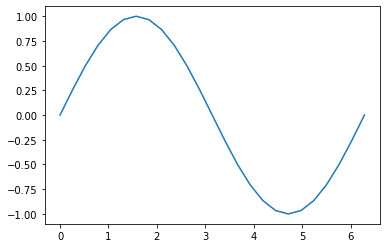

In [41]:
import torch

import matplotlib.pyplot as plt
import math

a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)
b = torch.sin(a)
print(b)
plt.plot(a.detach(), b.detach())

In [42]:
c = 2 * b
d = c + 1
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


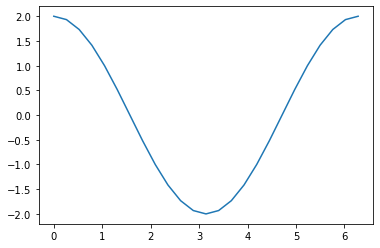

In [43]:
out.backward()  # call the backward to compute the gradient
print(a.grad)  # the gradient of out w.r.t. a
plt.plot(a.detach(), a.grad.detach())

#### Example 2

In [44]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

create another tensor Q from a and b.
\begin{align}
Q = 3a^3 - b^2
\end{align}

In [45]:
Q = 3*a**3 - b**2

then, we have
\begin{align}
\frac{\partial Q}{\partial a} = 9a^2 \\
\frac{\partial Q}{\partial b} = -2b
\end{align}
We want to call backward on Q to compute the gradients. \
To do this, we need to explicitly pass a gradient argument in `Q.backward()` because it is a vector, where gradient is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself, i.e.
\begin{align}
\frac{d Q}{d Q} = 1
\end{align}

In [46]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


### Set Hyperparameters

In [47]:
num_epochs = 15 # training epochs
lr = 0.01 # learning rate
logging_steps = 100 # logging batchsize
best_acc = 0.0 # best accuracy

### Model, Loss Function and Optimizer

In [48]:
model = TwoLayerNet(input_dim=784, num_classes=10, hidden_dims=300)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr)

# open the requires_grad flag for model parameters to use autograd(or/and computation graph)
for p in model.parameters():
    p.requires_grad = True

### Trainer

In [49]:
# Training for MLP Classification with Autograd
def train(model, criterion, train_loader, optimizer, epoch, logging_steps):

    loss_list = []
    acc_list = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # 0. data preprocessing
        inputs = torch.flatten(inputs, start_dim=1)

        # 1. reset gradient to zero
        optimizer.zero_grad()

        # 2. forward computation
        outputs = model.forward(inputs)
        loss = criterion.forward(outputs, targets)

        # 3. backward computation
        # the whole backward computation is performed by this single statement
        # note that manually defined backward functions are not used
        loss.backward()

        # 4. update parameters
        optimizer.step()

        # log
        _, predicted = outputs.max(1)
        total = targets.size(0)
        correct = predicted.eq(targets).sum().item()
        acc = correct / total
        loss_list.append(loss.item())
        acc_list.append(acc)

        if batch_idx % logging_steps == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.3f}\tAcc: {:.3f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                loss_list[-1], acc_list[-1]))

    return loss_list, acc_list


# Validation for MLP Classification with Autograd
def test(model, criterion, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = torch.flatten(inputs, start_dim=1)

            outputs = model.forward(inputs)
            loss = criterion.forward(outputs, targets)

            # log
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            num_batches += 1

    test_loss /= num_batches
    test_acc = correct / total
    return test_loss, test_acc


### Main Loop

In [50]:
print("Step 3: Training with Autograd")

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    tic = time.time()
    loss_list, acc_list = train(model, criterion, trainloader, optimizer, epoch, logging_steps)
    test_loss, test_acc = test(model, criterion, testloader)
    t = time.time() - tic
    
    train_loss_list.append(torch.mean(torch.as_tensor(loss_list)))
    train_acc_list.append(torch.mean(torch.as_tensor(acc_list)))
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
    print(f"Epoch {epoch} | Total Time: {t:.0f}s, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")
print(f"Best Accuracy: {best_acc:.3f}")


Step 3: Training with Autograd
Train Epoch: 0 [0/60000]	Loss: 2.303	Acc: 0.125
Train Epoch: 0 [12800/60000]	Loss: 1.431	Acc: 0.633
Train Epoch: 0 [25600/60000]	Loss: 1.089	Acc: 0.711
Train Epoch: 0 [38400/60000]	Loss: 0.913	Acc: 0.758
Train Epoch: 0 [51200/60000]	Loss: 0.685	Acc: 0.805
Epoch 0 | Total Time: 13s, Test Loss: 0.646, Test Acc: 0.813
Train Epoch: 1 [0/60000]	Loss: 0.590	Acc: 0.844
Train Epoch: 1 [12800/60000]	Loss: 0.596	Acc: 0.828
Train Epoch: 1 [25600/60000]	Loss: 0.398	Acc: 0.883
Train Epoch: 1 [38400/60000]	Loss: 0.337	Acc: 0.922
Train Epoch: 1 [51200/60000]	Loss: 0.338	Acc: 0.914
Epoch 1 | Total Time: 13s, Test Loss: 0.326, Test Acc: 0.912
Train Epoch: 2 [0/60000]	Loss: 0.378	Acc: 0.906
Train Epoch: 2 [12800/60000]	Loss: 0.280	Acc: 0.930
Train Epoch: 2 [25600/60000]	Loss: 0.268	Acc: 0.930
Train Epoch: 2 [38400/60000]	Loss: 0.177	Acc: 0.945
Train Epoch: 2 [51200/60000]	Loss: 0.327	Acc: 0.898
Epoch 2 | Total Time: 14s, Test Loss: 0.283, Test Acc: 0.922
Train Epoch: 3 [0/

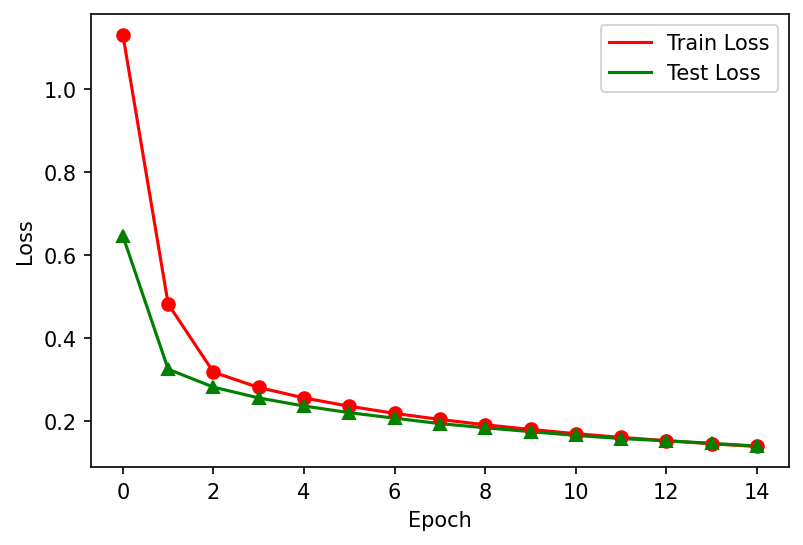

In [51]:
# plot loss and accuracy
epoch_list = range(num_epochs)
plt.figure(dpi=150)
l1 = plt.plot(epoch_list, train_loss_list, 'r-', label='Train Loss')
l2 = plt.plot(epoch_list, test_loss_list, 'g-', label='Test Loss')
plt.plot(epoch_list, train_loss_list, 'ro', epoch_list, test_loss_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

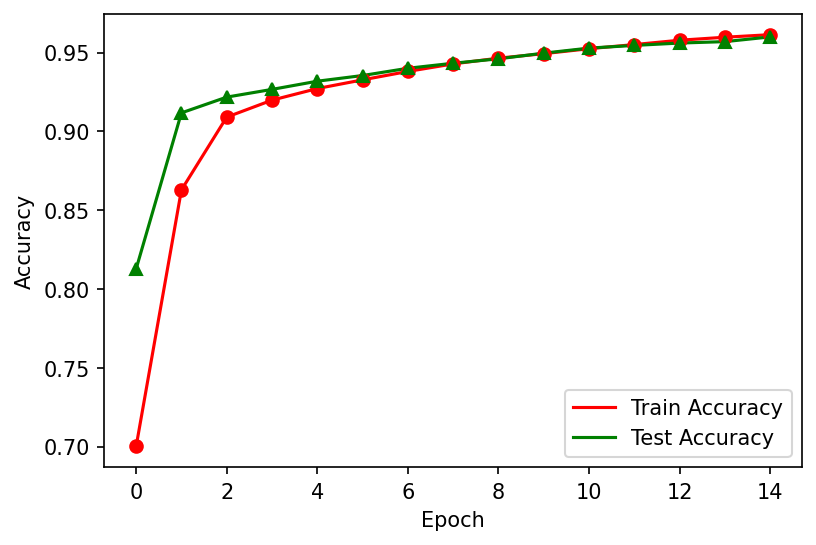

In [52]:
plt.figure(dpi=150)
l3 = plt.plot(epoch_list, train_acc_list, 'r-', label='Train Accuracy')
l4 = plt.plot(epoch_list, test_acc_list, 'g-', label='Test Accuracy')
plt.plot(epoch_list, train_acc_list, 'ro', epoch_list, test_acc_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Step 4: Training with torch.nn

### Import

In [ ]:
import torch.nn as nn
import torch.optim as optim
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"

### Define Model
`torch.nn` has built-in implementations for the above layers(Linear, ReLU, Sigmoid) and loss functions(MSE, BCE, CrossEntropy) \
Here we give an example about how to use `torch.nn` to construct your neural network.

In [ ]:
class ExampleModel(nn.Module):
    def __init__(self):
        super(ExampleModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Then, you need to construct the MLP architecture by yourself

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[]) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
        )
        
        for i in range(1, len(hidden_dims)):
            self.linear_relu_stack.add_module('linear_'+str(i), nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.linear_relu_stack.add_module('relu_'+str(i), nn.ReLU())
        
        self.linear_relu_stack.add_module('linear_'+str(len(hidden_dims)), nn.Linear(hidden_dims[-1], num_classes))
        # TODO, construct the MLP architecture with any number of hidden layers, with ReLU activation
        # HINT, The ExampleModel is a MLP with two hidden layers
        pass

    def forward(self, x):
        # TODO, implement this function
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        pass


### Set Hyperparameters

In [ ]:
num_epochs = 25  # training epochs
lr = 0.01  # learning rate
logging_steps = 100  # logging batchsize
best_acc = 0.0  # best accuracy

### Model, Loss Function and Optimizer

In [ ]:
# model with one hidden layer
# model = MLP(input_dim=784, num_classes=10, hidden_dims=[300])

# model with two hidden layers
model = MLP(input_dim=784, num_classes=10, hidden_dims=[512, 300])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = model.to(device)  # put the model on the specified device(e.g. gpu/cpu)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

### Trainer

In [ ]:
# Training for MLP Classification with torch.nn
def train(model, criterion, train_loader, optimizer, epoch, logging_steps):

    loss_list = []
    acc_list = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # 0. data preprocessing
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = torch.flatten(inputs, start_dim=1)

        # 1. reset gradient to zero
        optimizer.zero_grad()

        # 2. forward computation
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # 3. backward computation
        loss.backward()

        # 4. update parameters
        optimizer.step()

        # log
        _, predicted = outputs.max(1)
        total = targets.size(0)
        correct = predicted.eq(targets).sum().item()
        acc = correct / total
        loss_list.append(loss.item())
        acc_list.append(acc)

        if batch_idx % logging_steps == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.3f}\tAcc: {:.3f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                loss_list[-1], acc_list[-1]))

    return loss_list, acc_list


# Validation for MLP Classification with torch.nn
def test(model, criterion, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = torch.flatten(inputs, start_dim=1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # log
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            num_batches += 1

    test_loss /= num_batches
    test_acc = correct / total
    return test_loss, test_acc


### Main Loop

In [ ]:
print("Step 4: Training with torch.nn")

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    tic = time.time()
    loss_list, acc_list = train(model, criterion, trainloader, optimizer, epoch, logging_steps)
    test_loss, test_acc = test(model, criterion, testloader)
    t = time.time() - tic

    train_loss_list.append(loss_list[-1])
    train_acc_list.append(acc_list[-1])
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
    print(f"Epoch {epoch} | Total Time: {t:.0f}s, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")
print(f"Best Accuracy: {best_acc:.3f}")


In [ ]:
# plot loss and accuracy
epoch_list = range(num_epochs)
plt.figure(dpi=150)
l1 = plt.plot(epoch_list, train_loss_list, 'r-', label='Train Loss')
l2 = plt.plot(epoch_list, test_loss_list, 'g-', label='Test Loss')
plt.plot(epoch_list, train_loss_list, 'ro', epoch_list, test_loss_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=150)
l3 = plt.plot(epoch_list, train_acc_list, 'r-', label='Train Accuracy')
l4 = plt.plot(epoch_list, test_acc_list, 'g-', label='Test Accuracy')
plt.plot(epoch_list, train_acc_list, 'ro', epoch_list, test_acc_list, 'g^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()